In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mpl_finance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29104 sha256=27083b504ac0369b9597a6254c9873313a5028bc41f8b8046a30247344920429
  Stored in directory: /root/.cache/pip/wheels/31/31/f1/f2ff471bbc5b84a4b973698ceecdd453ae043971791adc3431
Successfully built ta


In [4]:
from mpl_finance import candlestick_ohlc
import matplotlib.pyplot as plt
import mpl_finance as mpf
import numpy as np
import pandas as pd
from matplotlib.pylab import date2num

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MMTC/Сбербанк.txt', sep=';', parse_dates= ["<DATE>"])[["<DATE>","<OPEN>",'<HIGH>','<LOW>','<CLOSE>','<VOL>']]
df['<DATE_1>'] =df['<DATE>'].apply(lambda x:date2num(x))

Text(0.5, 0, 'time')

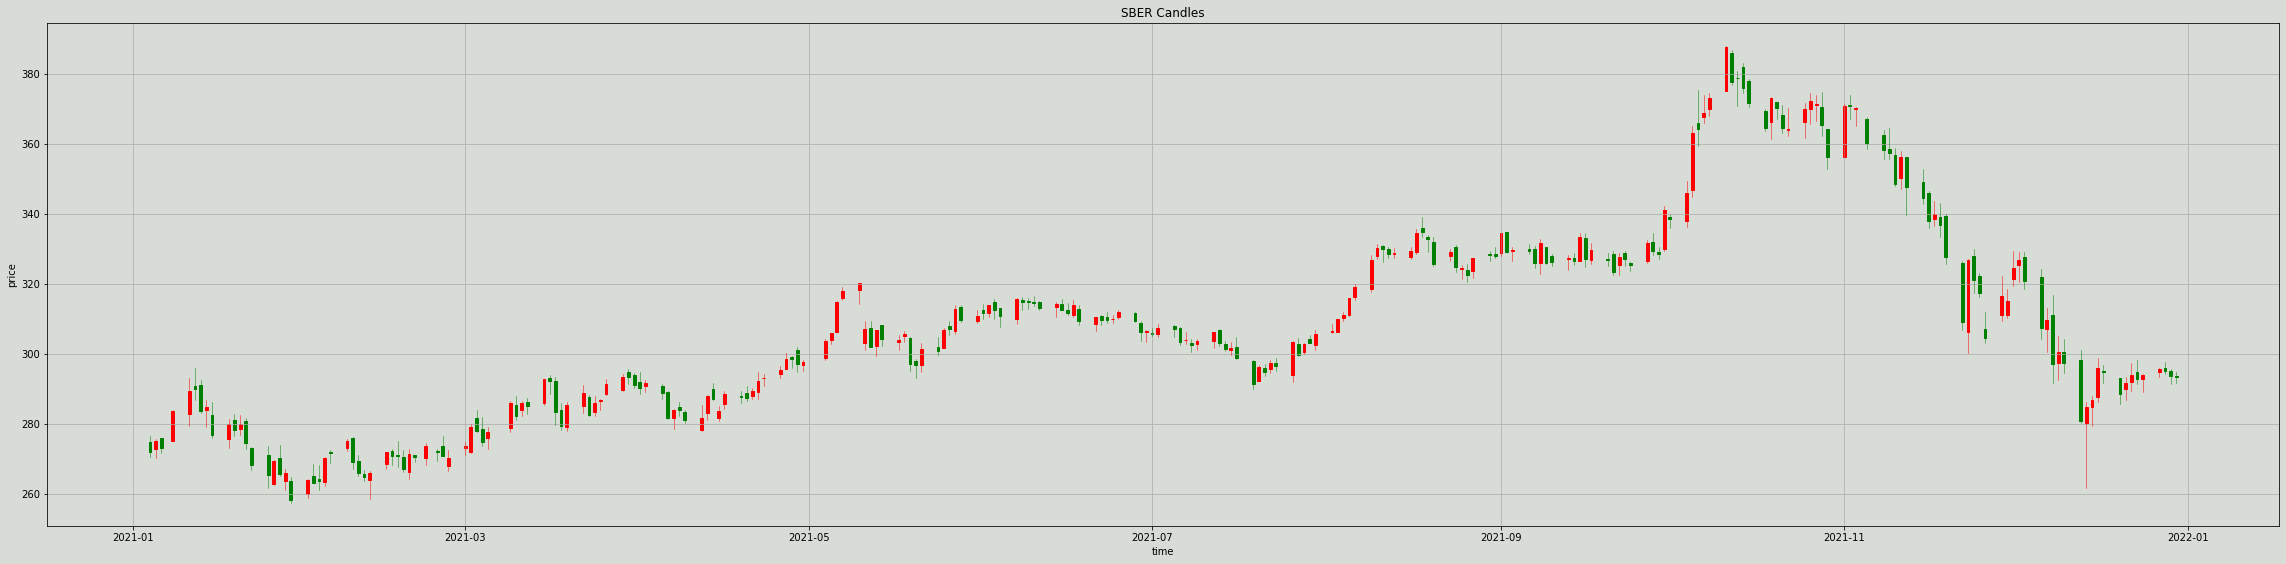

In [6]:
plt.figure(figsize = (40, 15), facecolor = '#d8dcd6')
ax = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)

candlestick_ohlc(ax,np.array(df[["<DATE_1>",	"<OPEN>",	"<HIGH>",	"<LOW>",	"<CLOSE>"]]),width=0.5,colorup='r',colordown='green') 

ax.set_title('SBER Candles')
ax.xaxis_date()
ax.set_ylabel('price')
ax.grid(True)
ax.set_facecolor('#d8dcd6')
ax.set_xlabel('time')

In [7]:
df["<VOL>"] = pd.to_numeric(df["<VOL>"], errors='coerce')
df["<VOL>"] = df["<VOL>"].fillna(0)

In [8]:
from ta import add_all_ta_features
import ta
df = add_all_ta_features(df, open="<OPEN>", high="<HIGH>", low="<LOW>", close="<CLOSE>", volume="<VOL>", fillna=True)

/usr/local/lib/python3.7/dist-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.7/dist-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


# Parabolic SAR

In [9]:
from ta.trend import PSARIndicator
Psar = PSARIndicator(high = df["<HIGH>"], low = df["<LOW>"], close = df["<CLOSE>"], step = 0.02, max_step = 0.2)
df["PSARu"] = Psar.psar_up()
df["PSARd"] = Psar.psar_down()

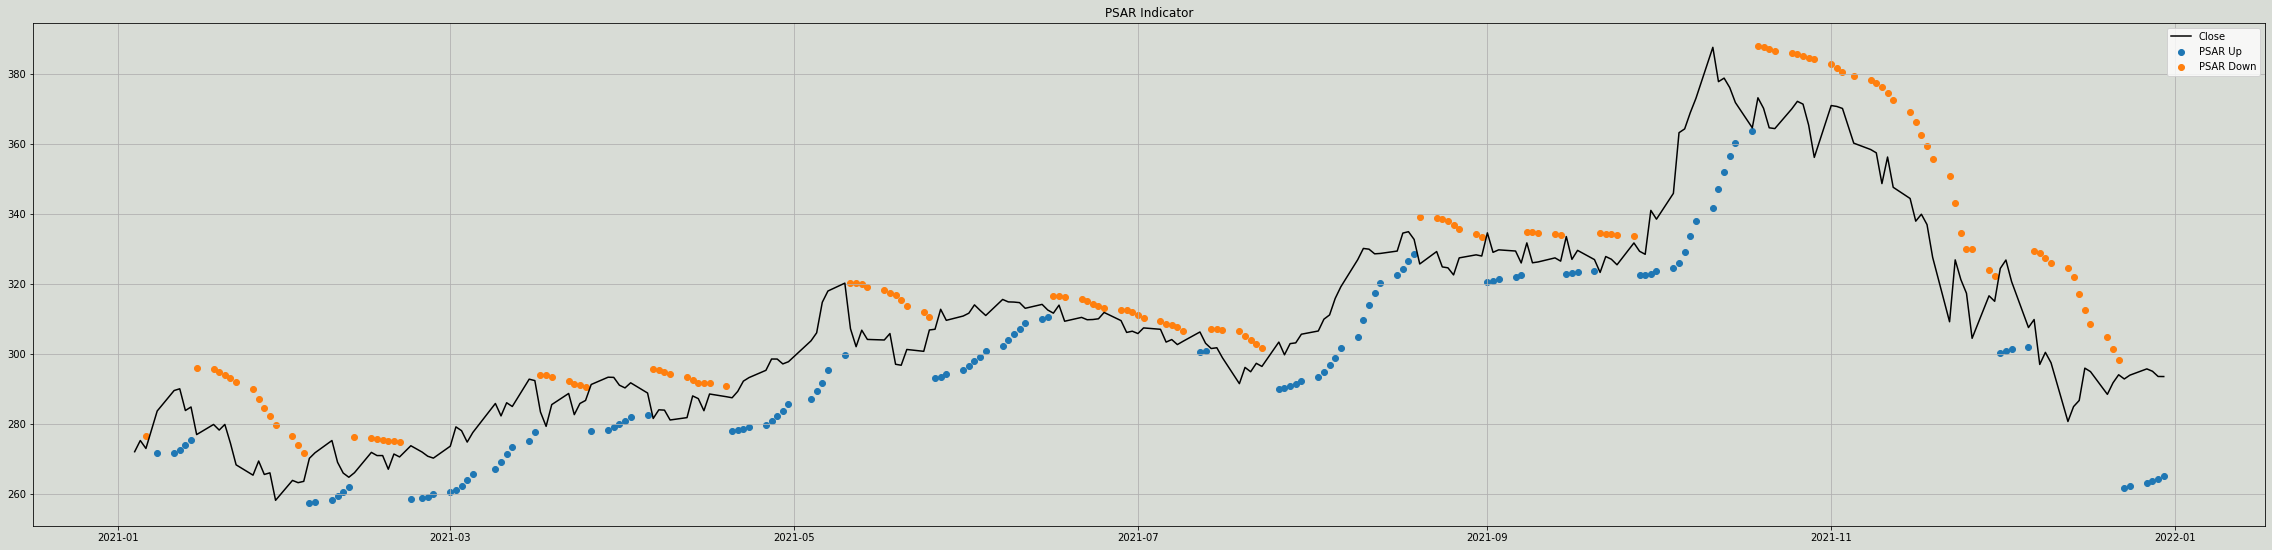

In [43]:
plt.figure(figsize = (40, 15), facecolor = '#d8dcd6')
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)

ax1.plot(df['<DATE>'],df['<CLOSE>'], label = 'Close', color = 'black')
ax1.scatter(df['<DATE>'],df['PSARu'], label = 'PSAR Up')
ax1.scatter(df['<DATE>'],df['PSARd'], label = 'PSAR Down')

ax1.set_title('PSAR Indicator')
ax1.legend(loc = 'best')
ax1.grid(True)
ax1.set_facecolor('#d8dcd6')

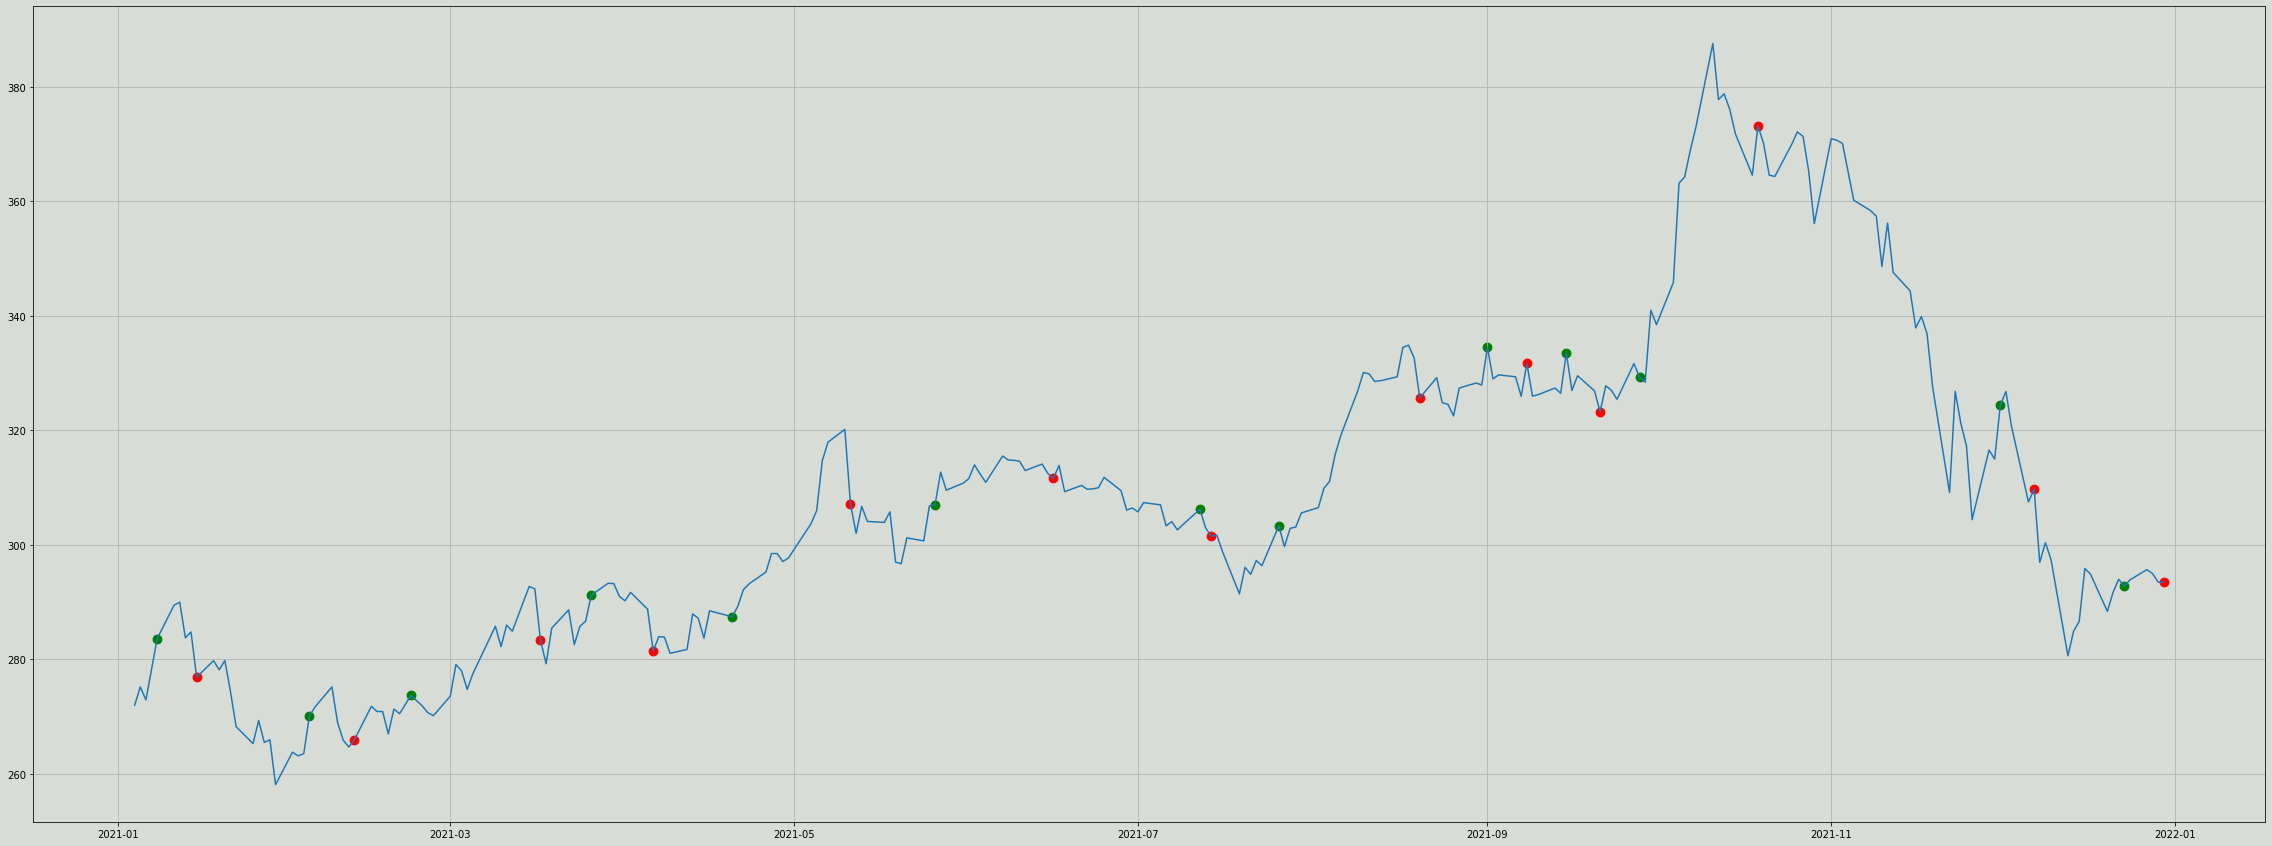

In [44]:
PSARdf = pd.DataFrame(df[['<DATE>', '<CLOSE>']])
balance = 100000
price = 0 
count = 0
# k = 0
balance_df, count_df, price_df, day_status = [], [], [], []
fig,ax=plt.subplots(facecolor="#d8dcd6",figsize=(40,15))
plt.plot(df['<DATE>'],df["<CLOSE>"])

for i in  range(len(df)):
  price = 0
  if i == 0:
    day_status.append('nothing')
  elif ((balance >= df['<CLOSE>'][i]) and (pd.isna(df["PSARd"][i]) == True and pd.isna(df["PSARd"][i-1]) == False)): 
    count += balance // df['<CLOSE>'][i]
    price = df['<CLOSE>'][i] * count
    balance = balance - price
    #k += price * 0.01
    day_status.append('buy')
    plt.scatter(df['<DATE>'][i] , df['<CLOSE>'][i], c='green', s=78)
  
  elif count > 0 and (pd.isna(df["PSARu"][i]) == True and pd.isna(df["PSARu"][i-1]) == False):
    balance += count * df['<CLOSE>'][i]
    #k += count * df['<CLOSE>'][i] * 0.01
    count = 0
    price = df['<CLOSE>'][i]
    day_status.append('sell')
    plt.scatter(df['<DATE>'][i] , df['<CLOSE>'][i], c='red', s=78)

  elif i == (len(df)-1) and count>0:
    balance += count * df['<CLOSE>'][i]
    #k += count * df['<CLOSE>'][i] * 0.01
    count = 0
    price = df['<CLOSE>'][i]
    day_status.append('sell')
    #print(f'Комиссия за всё время: {k}')
    #balance -= k
    plt.scatter(df['<DATE>'][i] , df['<CLOSE>'][i], c='red', s=78)
  else:
    day_status.append('nothing')
  
  count_df.append(count)
  balance_df.append(balance)
  price_df.append(price)

ax.set_facecolor('#d8dcd6')
ax.grid(True)

PSARdf["NumOfShares"] = count_df
PSARdf["MoneySpent"] = price_df
PSARdf["Balance"] = balance_df
PSARdf["DayStatus"] = day_status

In [45]:
PSARdf[(PSARdf['DayStatus'] == 'buy') | (PSARdf['DayStatus'] == 'sell')]

<DATE>  <CLOSE>  NumOfShares  MoneySpent    Balance DayStatus
3   2021-01-08   283.64        352.0    99841.28     158.72       buy
8   2021-01-15   276.90          0.0      276.90   97627.52      sell
22  2021-02-04   270.11        361.0    97509.71     117.81       buy
28  2021-02-12   266.00          0.0      266.00   96143.81      sell
35  2021-02-22   273.71        351.0    96072.21      71.60       buy
50  2021-03-17   283.35          0.0      283.35   99527.45      sell
57  2021-03-26   291.22        341.0    99306.02     221.43       buy
64  2021-04-06   281.50          0.0      281.50   96212.93      sell
74  2021-04-20   287.42        334.0    95998.28     214.65       buy
88  2021-05-11   307.16          0.0      307.16  102806.09      sell
99  2021-05-26   307.01        334.0   102541.34     264.75       buy
114 2021-06-16   311.61          0.0      311.61  104342.49      sell
132 2021-07-12   306.23        340.0   104118.20     224.29       buy
134 2021-07-14   301.50          0.0      301.50  102734.29      sell
142 2021-07-26   303.34        338.0   102528.92     205.37       buy
161 2021-08-20   325.67          0.0      325.67  110281.83      sell
169 2021-09-01   334.57        329.0   110073.53     208.30       buy
174 2021-09-08   331.70          0.0      331.70  109337.60      sell
179 2021-09-15   333.51        327.0   109057.77     279.83       buy
183 2021-09-21   323.25          0.0      323.25  105982.58      sell
188 2021-09-28   329.30        321.0   105705.30     277.28       buy
203 2021-10-19   373.18          0.0      373.18  120068.06      sell
233 2021-12-01   324.40        370.0   120028.00      40.06       buy
237 2021-12-07   309.79          0.0      309.79  114662.36      sell
249 2021-12-23   292.80        391.0   114484.80     177.56       buy
254 2021-12-30   293.49          0.0      293.49  114932.15      sell

# RSI

In [27]:
from ta.momentum import RSIIndicator
df["RSI"] = RSIIndicator(df['<CLOSE>'], 10).rsi()

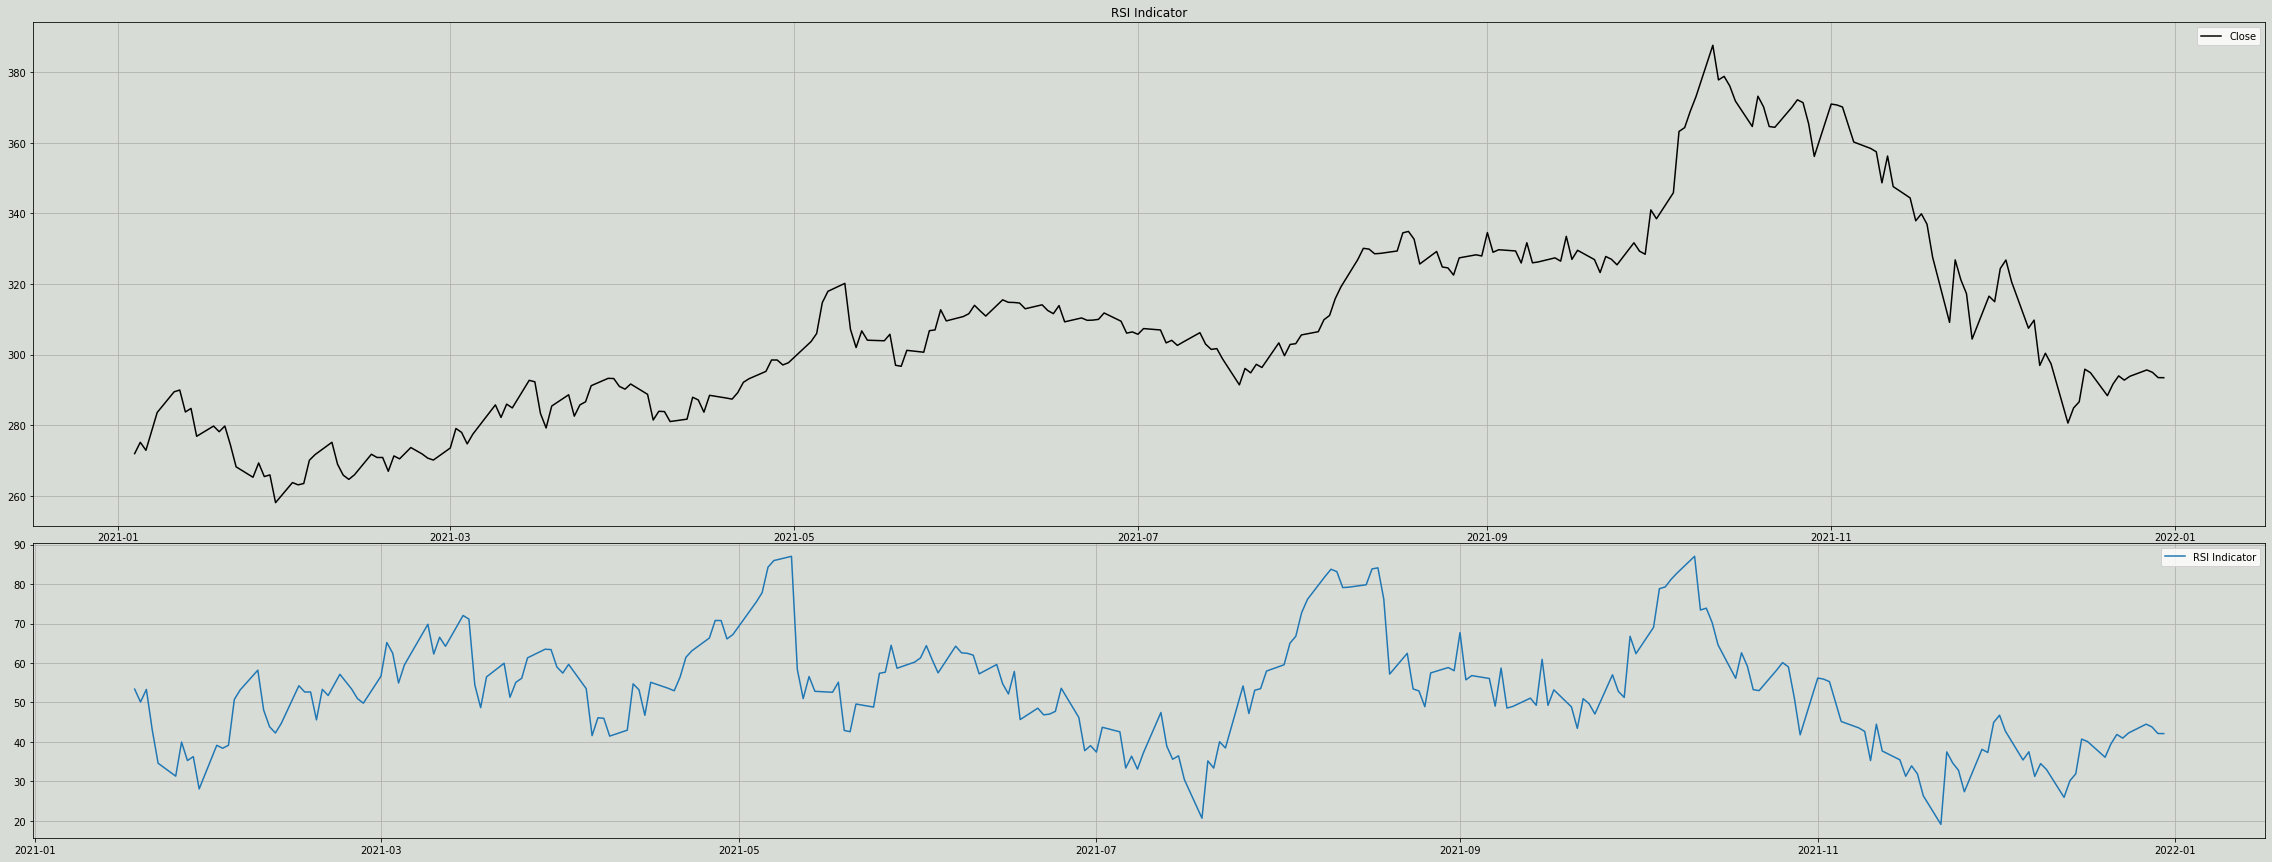

In [28]:
plt.figure(figsize = (40, 15), facecolor = '#d8dcd6')
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(df['<DATE>'],df['<CLOSE>'], label = 'Close', color = 'black')
ax2.plot(df['<DATE>'],df['RSI'], label = 'RSI Indicator')

ax1.set_title('RSI Indicator')
ax1.legend(loc = 'best')
ax2.legend(loc = 'best')

ax1.grid(True)
ax2.grid(True)

ax1.set_facecolor('#d8dcd6')
ax2.set_facecolor('#d8dcd6')

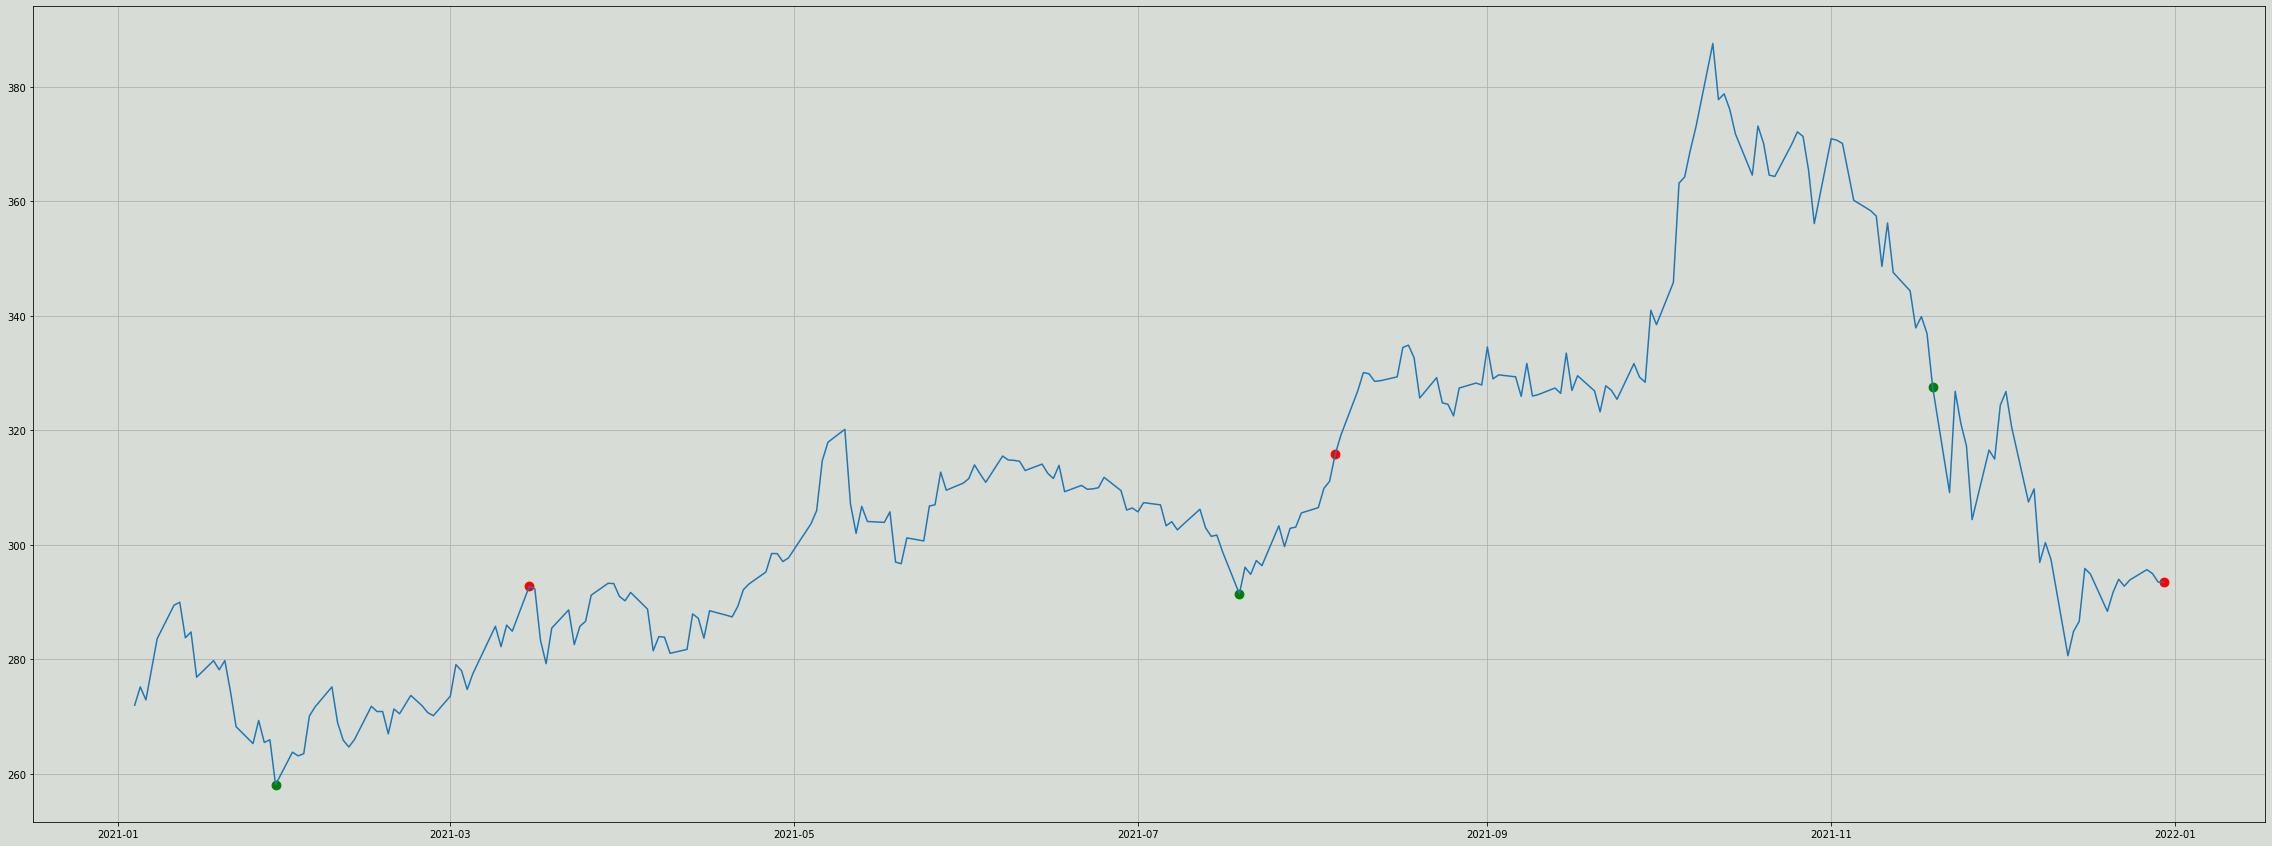

In [29]:
RSIdf = pd.DataFrame(df[['<DATE>', '<CLOSE>']])
balance = 100000
price = 0 
count = 0
# k = 0
balance_df, count_df, price_df, day_status = [], [], [], []
fig,ax=plt.subplots(facecolor="#d8dcd6",figsize=(40,15))
plt.plot(df['<DATE>'],df["<CLOSE>"])

for i in  range(len(df)):
  price = 0
  if i == 0:
    day_status.append('nothing')
  elif ((balance >= df['<CLOSE>'][i]) and (df["RSI"][i]<30 and df["RSI"][i-1]>30)): 
    count += balance // df['<CLOSE>'][i]
    price = df['<CLOSE>'][i] * count
    balance = balance - price
    #k += price * 0.01
    day_status.append('buy')
    plt.scatter(df['<DATE>'][i] , df['<CLOSE>'][i], c='green', s=78)
  
  elif count > 0 and (df["RSI"][i]>70):
    balance += count * df['<CLOSE>'][i]
    #k += count * df['<CLOSE>'][i] * 0.01
    count = 0
    price = df['<CLOSE>'][i]
    day_status.append('sell')
    plt.scatter(df['<DATE>'][i] , df['<CLOSE>'][i], c='red', s=78)

  elif i == (len(df)-1) and count>0:
    balance += count * df['<CLOSE>'][i]
    #k += count * df['<CLOSE>'][i] * 0.01
    count = 0
    price = df['<CLOSE>'][i]
    day_status.append('sell')
    #print(f'Комиссия за всё время: {k}')
    #balance -= k
    plt.scatter(df['<DATE>'][i] , df['<CLOSE>'][i], c='red', s=78)
  else:
    day_status.append('nothing')
  
  count_df.append(count)
  balance_df.append(balance)
  price_df.append(price)

ax.set_facecolor('#d8dcd6')
ax.grid(True)

RSIdf["NumOfShares"] = count_df
RSIdf["MoneySpent"] = price_df
RSIdf["Balance"] = balance_df
RSIdf["DayStatus"] = day_status

In [30]:
RSIdf[(RSIdf['DayStatus'] == 'buy') | (RSIdf['DayStatus'] == 'sell')]

<DATE>  <CLOSE>  NumOfShares  MoneySpent    Balance DayStatus
18  2021-01-29   258.11        387.0    99888.57     111.43       buy
48  2021-03-15   292.74          0.0      292.74  113401.81      sell
137 2021-07-19   291.46        389.0   113377.94      23.87       buy
150 2021-08-05   315.82          0.0      315.82  122877.85      sell
225 2021-11-19   327.56        375.0   122835.00      42.85       buy
254 2021-12-30   293.49          0.0      293.49  110101.60      sell

#Stochastic

In [46]:
from ta.momentum import StochasticOscillator
St = StochasticOscillator(high = df["<HIGH>"], low = df["<LOW>"], close = df["<CLOSE>"])
df["Stoch"] = St.stoch()
df["StochSig"] = St.stoch_signal()

In [47]:
from ta.trend import MACD
MACD = MACD(df["<CLOSE>"], window_fast = 11, window_slow = 27, window_sign = 9)
df["MACD"] = MACD.macd()
df["MACD_signal"] = MACD.macd_signal()
df["MACD_gist"] = MACD.macd_diff()

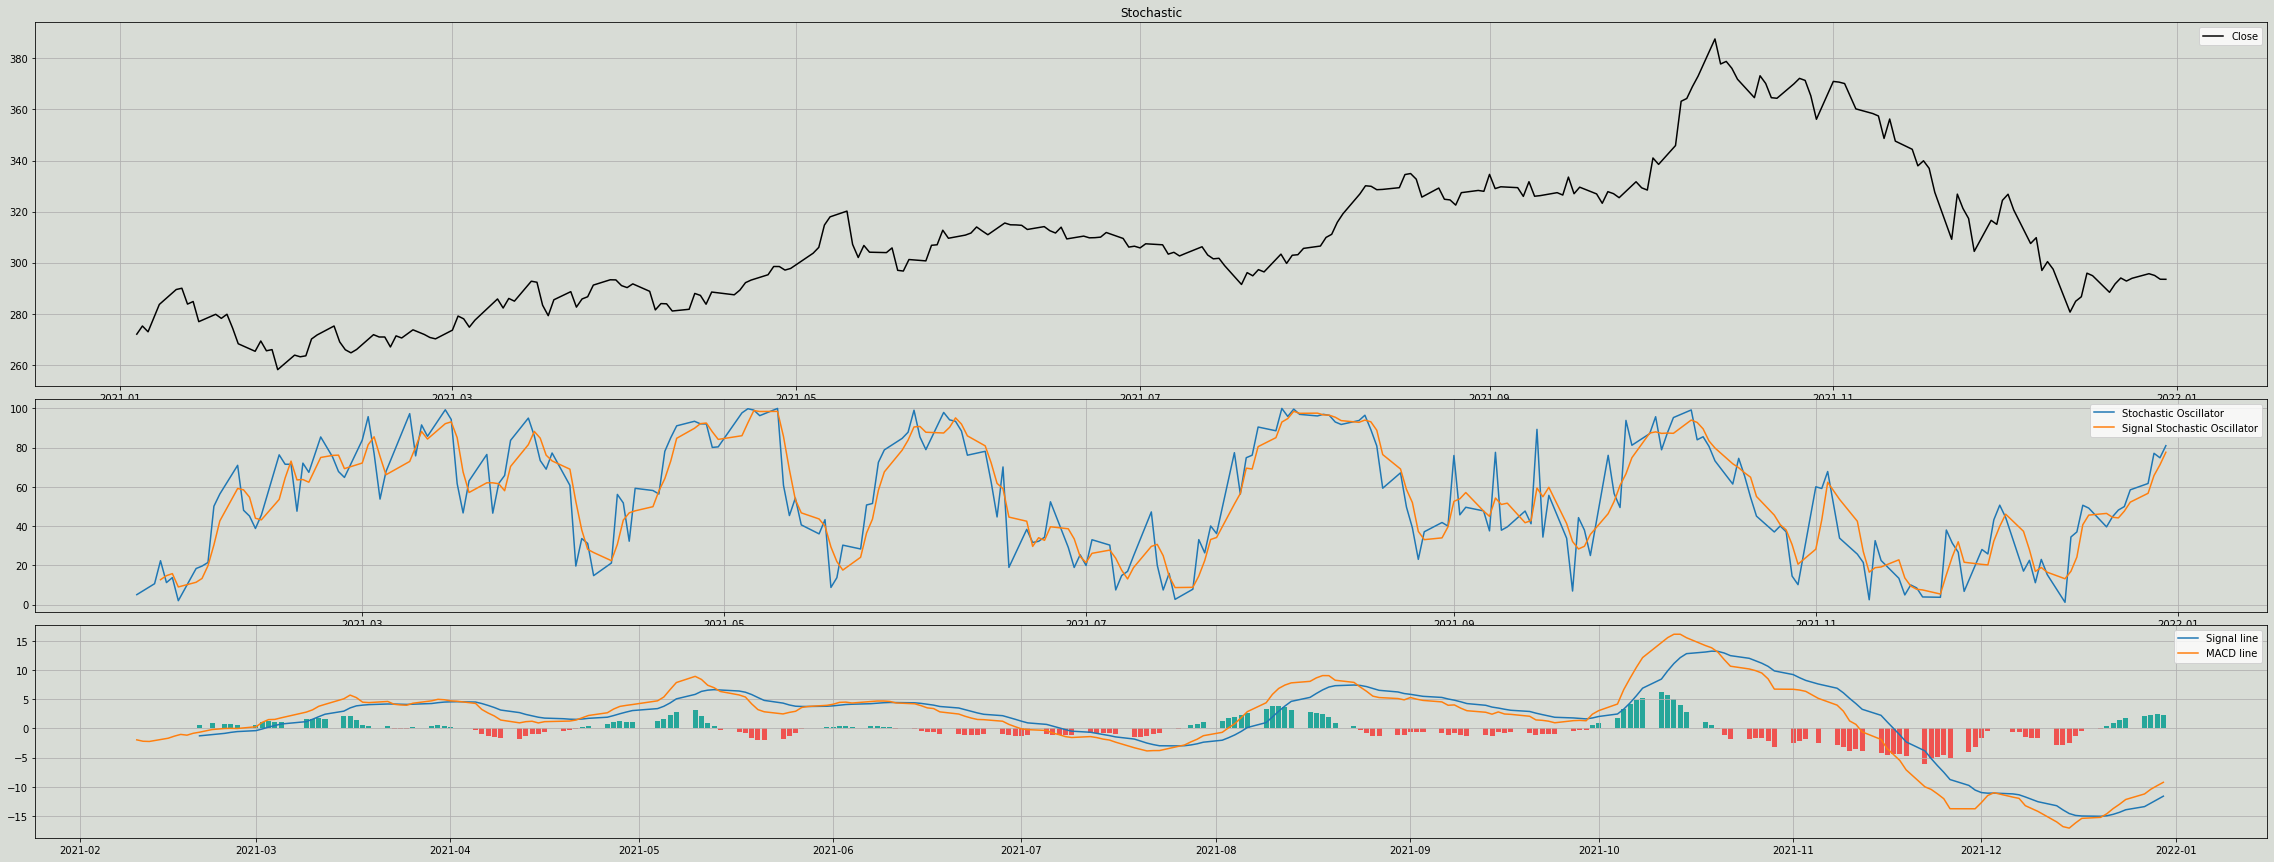

In [48]:
plt.figure(figsize = (40, 15), facecolor = '#d8dcd6')
ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (5,0), rowspan = 3, colspan = 1)
ax3 = plt.subplot2grid((11,1), (8,0), rowspan = 3, colspan = 1)

ax1.plot(df['<DATE>'],df['<CLOSE>'], label = 'Close', color = 'black')

ax2.plot(df['<DATE>'],df['Stoch'], label = 'Stochastic Oscillator')
ax2.plot(df['<DATE>'],df['StochSig'], label = 'Signal Stochastic Oscillator')

ax3.plot(df['<DATE>'],df['MACD_signal'], label = 'Signal line')
ax3.plot(df['<DATE>'],df['MACD'], label = 'MACD line')

axs = [ax1, ax2, ax3]
for i in range(len(df)):
    if str(df['MACD_gist'][i])[0] == '-':
        ax3.bar(df['<DATE>'][i], df['MACD_gist'][i], color = '#ef5350',)
    else:
        ax3.bar(df['<DATE>'][i], df['MACD_gist'][i], color = '#26a69a')

ax1.set_title('Stochastic')
for i in axs:
  i.legend(loc = 'best')
  i.grid(True)
  i.set_facecolor('#d8dcd6')

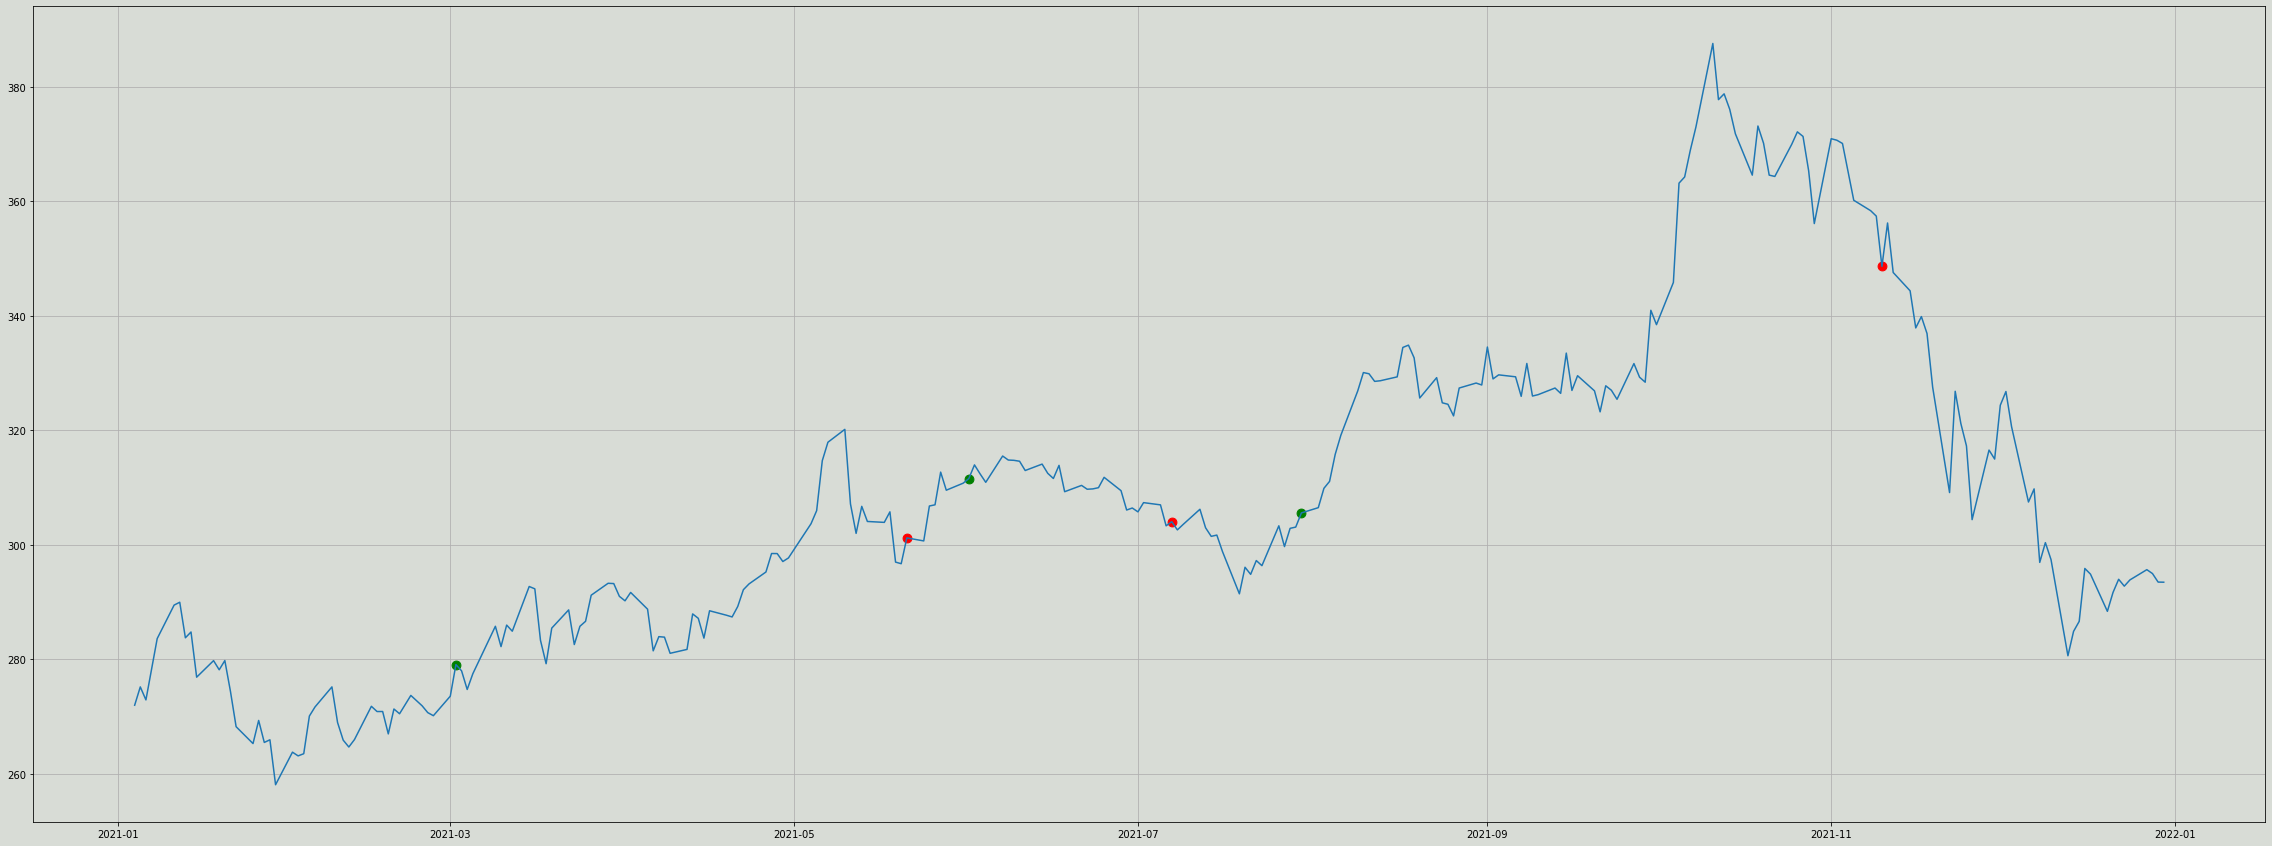

In [50]:
Stochdf = pd.DataFrame(df[['<DATE>', '<CLOSE>']])
balance = 100000
price = 0 
count = 0
# k = 0
balance_df, count_df, price_df, day_status = [], [], [], []
fig,ax=plt.subplots(facecolor="#d8dcd6",figsize=(40,15))
plt.plot(df['<DATE>'],df["<CLOSE>"])

for i in  range(len(df)):
  price = 0
  if i == 0:
    day_status.append('nothing')
  elif ((balance >= df['<CLOSE>'][i]) and (df["MACD_gist"][i] > 0 and df["StochSig"][i] > 80 and df["StochSig"][i-1] < 80)): 
    count += balance // df['<CLOSE>'][i]
    price = df['<CLOSE>'][i] * count
    balance = balance - price
    #k += price * 0.01
    day_status.append('buy')
    plt.scatter(df['<DATE>'][i] , df['<CLOSE>'][i], c='green', s=78)
  
  elif count > 0 and (df["MACD_gist"][i] < 0 and df["StochSig"][i] < 20 and df["StochSig"][i-1] > 20):
    balance += count * df['<CLOSE>'][i]
    #k += count * df['<CLOSE>'][i] * 0.01
    count = 0
    price = df['<CLOSE>'][i]
    day_status.append('sell')
    plt.scatter(df['<DATE>'][i] , df['<CLOSE>'][i], c='red', s=78)

  elif i == (len(df)-1) and count>0:
    balance += count * df['<CLOSE>'][i]
    #k += count * df['<CLOSE>'][i] * 0.01
    count = 0
    price = df['<CLOSE>'][i]
    day_status.append('sell')
    #print(f'Комиссия за всё время: {k}')
    #balance -= k
    plt.scatter(df['<DATE>'][i] , df['<CLOSE>'][i], c='red', s=78)
  else:
    day_status.append('nothing')
  
  count_df.append(count)
  balance_df.append(balance)
  price_df.append(price)

ax.set_facecolor('#d8dcd6')
ax.grid(True)

Stochdf["NumOfShares"] = count_df
Stochdf["MoneySpent"] = price_df
Stochdf["Balance"] = balance_df
Stochdf["DayStatus"] = day_status

In [51]:
Stochdf[(Stochdf['DayStatus'] == 'buy') | (Stochdf['DayStatus'] == 'sell')]

<DATE>  <CLOSE>  NumOfShares  MoneySpent    Balance DayStatus
40  2021-03-02   279.10        358.0    99917.80      82.20       buy
96  2021-05-21   301.23          0.0      301.23  107922.54      sell
103 2021-06-01   311.60        346.0   107813.60     108.94       buy
129 2021-07-07   304.06          0.0      304.06  105313.70      sell
146 2021-07-30   305.59        344.0   105122.96     190.74       buy
218 2021-11-10   348.65          0.0      348.65  120126.34      sell

# IVAR